# Load Packages and State Paths


In [1]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision import transforms
import nibabel as nib
import random
from torch.utils.data import DataLoader
import time



final_project_path = '/home/jws2215/e6691-2024spring-project-jwss-jws2215' # vm
data_folder_path = os.path.join(final_project_path, 'BraTS2020')
train_folder_path = os.path.join(data_folder_path, 'train')
valid_folder_path = os.path.join(data_folder_path, 'valid')


if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name: ", torch.cuda.get_device_name(0))
    allocated_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert bytes to gigabytes
    cached_memory = torch.cuda.memory_reserved() / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Allocated Memory: {allocated_memory:.2f} GB")
    print(f"Cached Memory: {cached_memory:.2f} GB")
    total_memory = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Total GPU Memory: {total_memory:.2f} GB")
else:
    print("CUDA is not available. Cannot print memory usage.")
    device = torch.device('cpu')



GPU name:  Tesla T4
Allocated Memory: 0.00 GB
Cached Memory: 0.00 GB
Total GPU Memory: 14.58 GB


# Create the Dataset

In [2]:
def create_data_dictionary(folder_path):
    data_dict = {}
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    
    for idx, subfolder in enumerate(subfolders):
        abs_path = os.path.join(folder_path, subfolder)
        data_dict[idx] = {'absolute_path': abs_path, 'folder_name': subfolder}
    
    return data_dict

data_path_dictionary_train = create_data_dictionary(train_folder_path)
data_path_dictionary_valid = create_data_dictionary(valid_folder_path)

print("Train Data Dictionary:")
for idx, data in data_path_dictionary_train.items():
    print(f"Index: {idx}, Absolute Path: {data['absolute_path']}, Folder Name: {data['folder_name']}")

print("\nValid Data Dictionary:")
for idx, data in data_path_dictionary_valid.items():
    print(f"Index: {idx}, Absolute Path: {data['absolute_path']}, Folder Name: {data['folder_name']}")


Train Data Dictionary:
Index: 0, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_099, Folder Name: BraTS20_Training_099
Index: 1, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_036, Folder Name: BraTS20_Training_036
Index: 2, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_004, Folder Name: BraTS20_Training_004
Index: 3, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_029, Folder Name: BraTS20_Training_029
Index: 4, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_021, Folder Name: BraTS20_Training_021
Index: 5, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2020/train/BraTS20_Training_058, Folder Name: BraTS20_Training_058
Index: 6, Absolute Path: /home/jws2215/e6691-2024spring-project-jwss-jws2215/BraTS2

In [3]:
## all data is stored in (240,240,155) 

class ImageDataset(Dataset):
    def __init__(self, data_path_dictionary):
        self.data_path_dictionary = data_path_dictionary

    def __len__(self):
        # print(len(self.annotations["images"]))
        return len(self.data_path_dictionary)

    def __getitem__(self, idx):
        
        folder_name = self.data_path_dictionary[idx]["folder_name"]
        folder_path = self.data_path_dictionary[idx]["absolute_path"]
        
        seg_path = os.path.join(folder_path, folder_name + '_seg.nii')
        t1_path = os.path.join(folder_path, folder_name + '_t1.nii')
        t1ce_path = os.path.join(folder_path, folder_name + '_t1ce.nii')
        t2_path = os.path.join(folder_path, folder_name + '_t2.nii')
        flair_path = os.path.join(folder_path, folder_name + '_flair.nii')
        
        # Load .nii files as nparrays
        seg_img = nib.load(seg_path).get_fdata()
        
        t1_img = nib.load(t1_path).get_fdata() #combine these ones
        t1ce_img = nib.load(t1ce_path).get_fdata()#combine these ones
        t2_img = nib.load(t2_path).get_fdata()#combine these ones
        flair_img = nib.load(flair_path).get_fdata()#combine these ones
        
        # Combine the MRI scans into a single 4-channel image
        combined_mri = np.stack([t1_img, t1ce_img, t2_img, flair_img], axis=2)
        
        # Convert combined_mri and seg_img to torch tensors
        combined_mri = torch.tensor(combined_mri, dtype=torch.float32)
        seg_img = torch.tensor(seg_img, dtype=torch.float32)


        return combined_mri, seg_img



Train Dataset <__main__.ImageDataset object at 0x7fa63fdb8a30>
Val Dataset <__main__.ImageDataset object at 0x7fa63fdbbb20>
Length of train dataset: 80
Length of validation dataset: 20
Shape of combined_mri for index 1: torch.Size([240, 240, 4, 155])


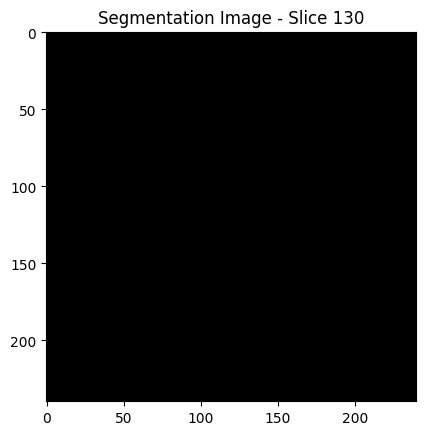

Shape of combined_mri for validation index 17: torch.Size([240, 240, 4, 155])


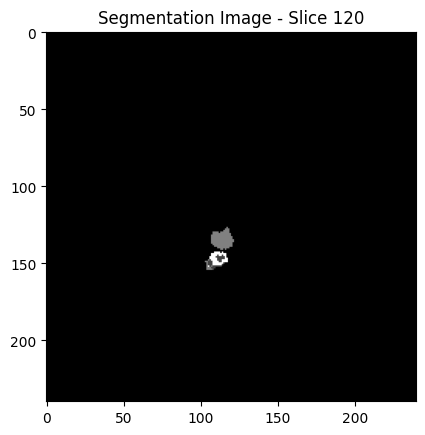

In [4]:
# Actually create the datasets

train_dataset = ImageDataset(data_path_dictionary_train)
val_dataset = ImageDataset(data_path_dictionary_valid)

print("Train Dataset", train_dataset)
print("Val Dataset", val_dataset)

print("Length of train dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

# Helper function to display a random slice
def display_random_slice(seg_img):
    random_slice = random.randint(0, seg_img.shape[2] - 1)
    plt.imshow(seg_img[:, :, random_slice], cmap='gray')
    plt.title(f'Segmentation Image - Slice {random_slice}')
    plt.show()

# Get a random index
random_idx = random.randint(0, len(train_dataset) - 1)

# Get the data for that index
combined_mri, seg_img = train_dataset[random_idx]

# Print shape of combined_mri
print(f"Shape of combined_mri for index {random_idx}: {combined_mri.shape}")

# Display a random slice of seg_img
display_random_slice(seg_img)

# Repeat for validation dataset
random_idx = random.randint(0, len(val_dataset) - 1)
combined_mri, seg_img = val_dataset[random_idx]
print(f"Shape of combined_mri for validation index {random_idx}: {combined_mri.shape}")
display_random_slice(seg_img)


In [5]:
# Define batch size
batch_size = 2  # remember each item in a batch actually contains 155 subbatches

# Create DataLoader instances for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("train_loader", train_loader)
print("val_loader", val_loader)

train_loader <torch.utils.data.dataloader.DataLoader object at 0x7fa63fdb9a50>
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7fa63fdb8c70>


# The Model

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.encoder_conv1 = self.conv_block(in_channels, 64)
        
        self.encoder_conv2 = self.conv_block(64, 128)
        
        self.encoder_conv3 = self.conv_block(128, 256)
        
        self.encoder_conv4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (upsampling path)
        self.decoder_upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder_conv1 = self.conv_block(1024, 512)
        
        self.decoder_upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_conv2 = self.conv_block(512, 256)
        
        self.decoder_upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv3 = self.conv_block(256, 128)
        
        self.decoder_upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv4 = self.conv_block(128, 64)

        # Output layer
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        enc2 = self.encoder_conv2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder_conv3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.encoder_conv4(F.max_pool2d(enc3, kernel_size=2, stride=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))

        # Decoder
        dec1 = self.decoder_upconv1(bottleneck)
        dec1 = self.decoder_conv1(torch.cat([enc4, dec1], dim=1))
        
        dec2 = self.decoder_upconv2(dec1)
        dec2 = self.decoder_conv2(torch.cat([enc3, dec2], dim=1))
        
        dec3 = self.decoder_upconv3(dec2)
        dec3 = self.decoder_conv3(torch.cat([enc2, dec3], dim=1))
        
        dec4 = self.decoder_upconv4(dec3)
        dec4 = self.decoder_conv4(torch.cat([enc1, dec4], dim=1))

        # Output layer
        output = self.output_conv(dec4)

        return torch.sigmoid(output)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

In [9]:
# Define the number of classes
num_output_classes = 5
num_input_channels = 4

# Custom Models
model = UNet(num_input_channels, num_output_classes)
model = model.to(device)

# Define the loss function
criterion =nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

# Print model summary
print(model)

UNet(
  (encoder_conv1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequ

In [10]:
# Training loop

num_epochs = 5 # Adjust as needed
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start timer for epoch
    model.train()
    running_train_loss = 0.0
    for combined_mris, seg_imgs in train_loader:
        # print("combined_mris", combined_mris.shape)
        # print("seg_imgs", seg_imgs.shape)
        
        for depth_idx in range(combined_mris.size(4)):  # Iterate over depth slices, should always be 155 anyways
            # Get the current depth slice and reshape it
            current_slice = combined_mris[:, :, :, :, depth_idx]
            current_slice = current_slice.permute(0, 3, 1, 2)  # Permute dimensions to [batch_size, channels, height, width]
            current_slice = current_slice.float().to(device)
            # Reshape seg_imgs for the current depth slice
            current_seg = seg_imgs[:, :, :, depth_idx].long().to(device)
            # print("current_slice", current_slice.shape)
            # print("current_seg", current_seg.shape)
            
            # Predict
            outputs = model(current_slice)
            
            # Compute loss for the current depth slice
            loss = criterion(outputs, current_seg)
            # print("loss", loss)
            running_train_loss += loss.item()
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for combined_mris, seg_imgs in val_loader:
            for depth_idx in range(combined_mris.size(4)):  # Iterate over depth slices, should always be 155 anyways
                # Get the current depth slice and reshape it
                current_slice = combined_mris[:, :, :, :, depth_idx]
                current_slice = current_slice.permute(0, 3, 1, 2)  # Permute dimensions to [batch_size, channels, height, width]
                current_slice = current_slice.float().to(device)
                # Reshape seg_imgs for the current depth slice
                current_seg = seg_imgs[:, :, :, depth_idx].long().to(device)

                # Predict
                outputs = model(current_slice)

                # Compute loss for the current depth slice
                loss = criterion(outputs, current_seg)
                running_val_loss += loss.item()
                

       
            
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    
    end_time = time.time()  # End timer for epoch
    epoch_time = end_time - start_time  # Calculate epoch time
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Time: {epoch_time:.2f} seconds")


Epoch 1, Train Loss: 142.00362037718295, Val Loss: 141.36412203907966, Time: 881.93 seconds
Epoch 2, Train Loss: 141.65523086041213, Val Loss: 141.36412203907966, Time: 879.37 seconds



KeyboardInterrupt



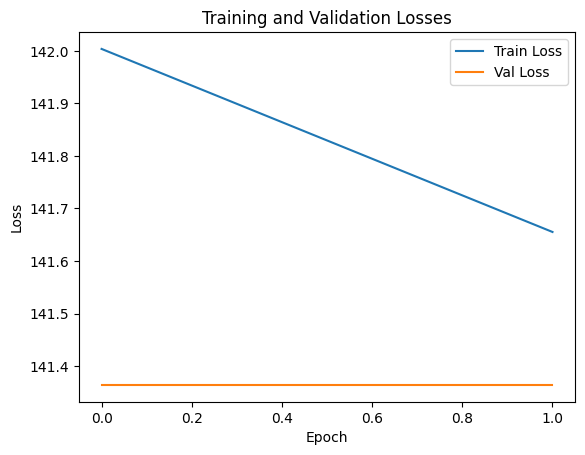

In [14]:
# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()